## NumPy


1.   Download the Intel Lab data available [here](https://db.csail.mit.edu/labdata/data.txt.gz). Read the documentation available [here](https://db.csail.mit.edu/labdata/labdata.html) As you can see the format of the data is much different compared to what we discussed in our previous NumPy scenarios. Do the following;
  1.   Load the data in an array
  2.   Delete the columns that do not correspond to mote measurements
  3. Search for nan values and replace them with a default value
  4. Cast the resulted array to dtype.float32
  5. Measurements of the same epoch may be shuffled in this file. Group them together in submatrices, 1 for each epoch.
  6. Concatenate the submatrices to end up with a single matrix
  7. Sort the resulted matrix based on the epoch number (Hint: a[a[:, i].argsort()] to sort by the i-th column --> check argsort [here](https://numpy.org/doc/stable/reference/generated/numpy.sort.html)).  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# File path
file_path = "intel_lab/data.txt"

# Define the column names and data types
dtypes = [
    ("date", "U10"), ("time", "U15"), ("epoch", "i4"), ("moteid", "i4"),
    ("temperature", "f4"), ("humidity", "f4"), ("light", "f4"), ("voltage", "f4")
]

# Load data
data = np.genfromtxt(
    file_path,
    delimiter=" ",  
    dtype=dtypes,   
    missing_values=" ",  
    filling_values=np.nan,  
    max_rows=2313153  # Read up to the 2313153, after that -> junk
)

# Keep only relevant columns
data = data[["epoch", "moteid", "temperature", "humidity", "light", "voltage"]]

# Filter the data to include only the moteids between 1 and 54 (documented on intel lab website)
data = data[(data["moteid"] >= 1) & (data["moteid"] <= 54)]

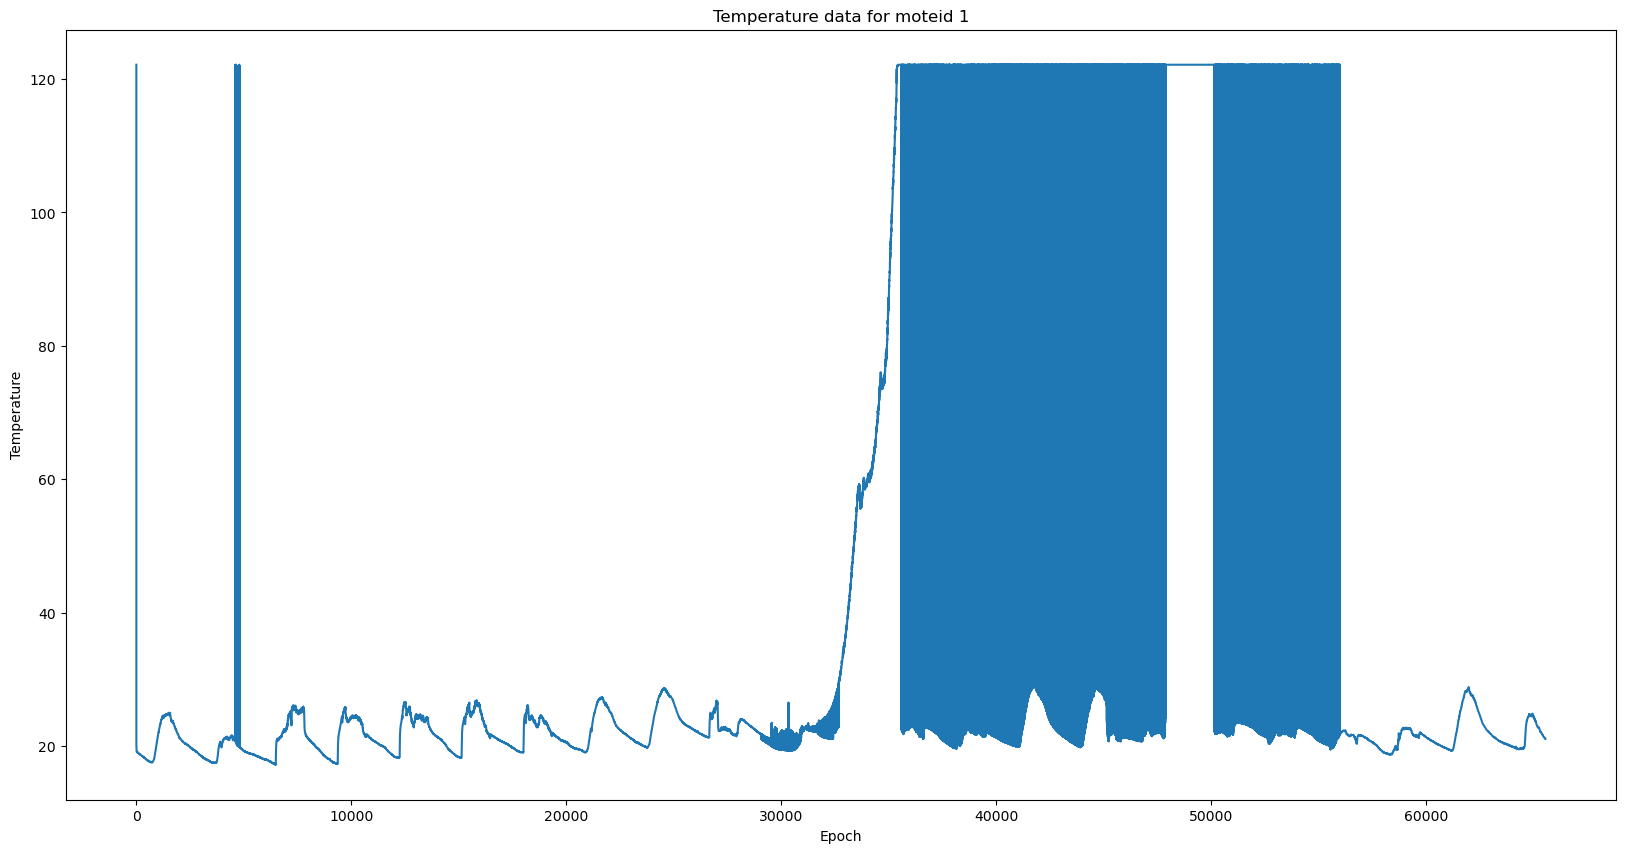

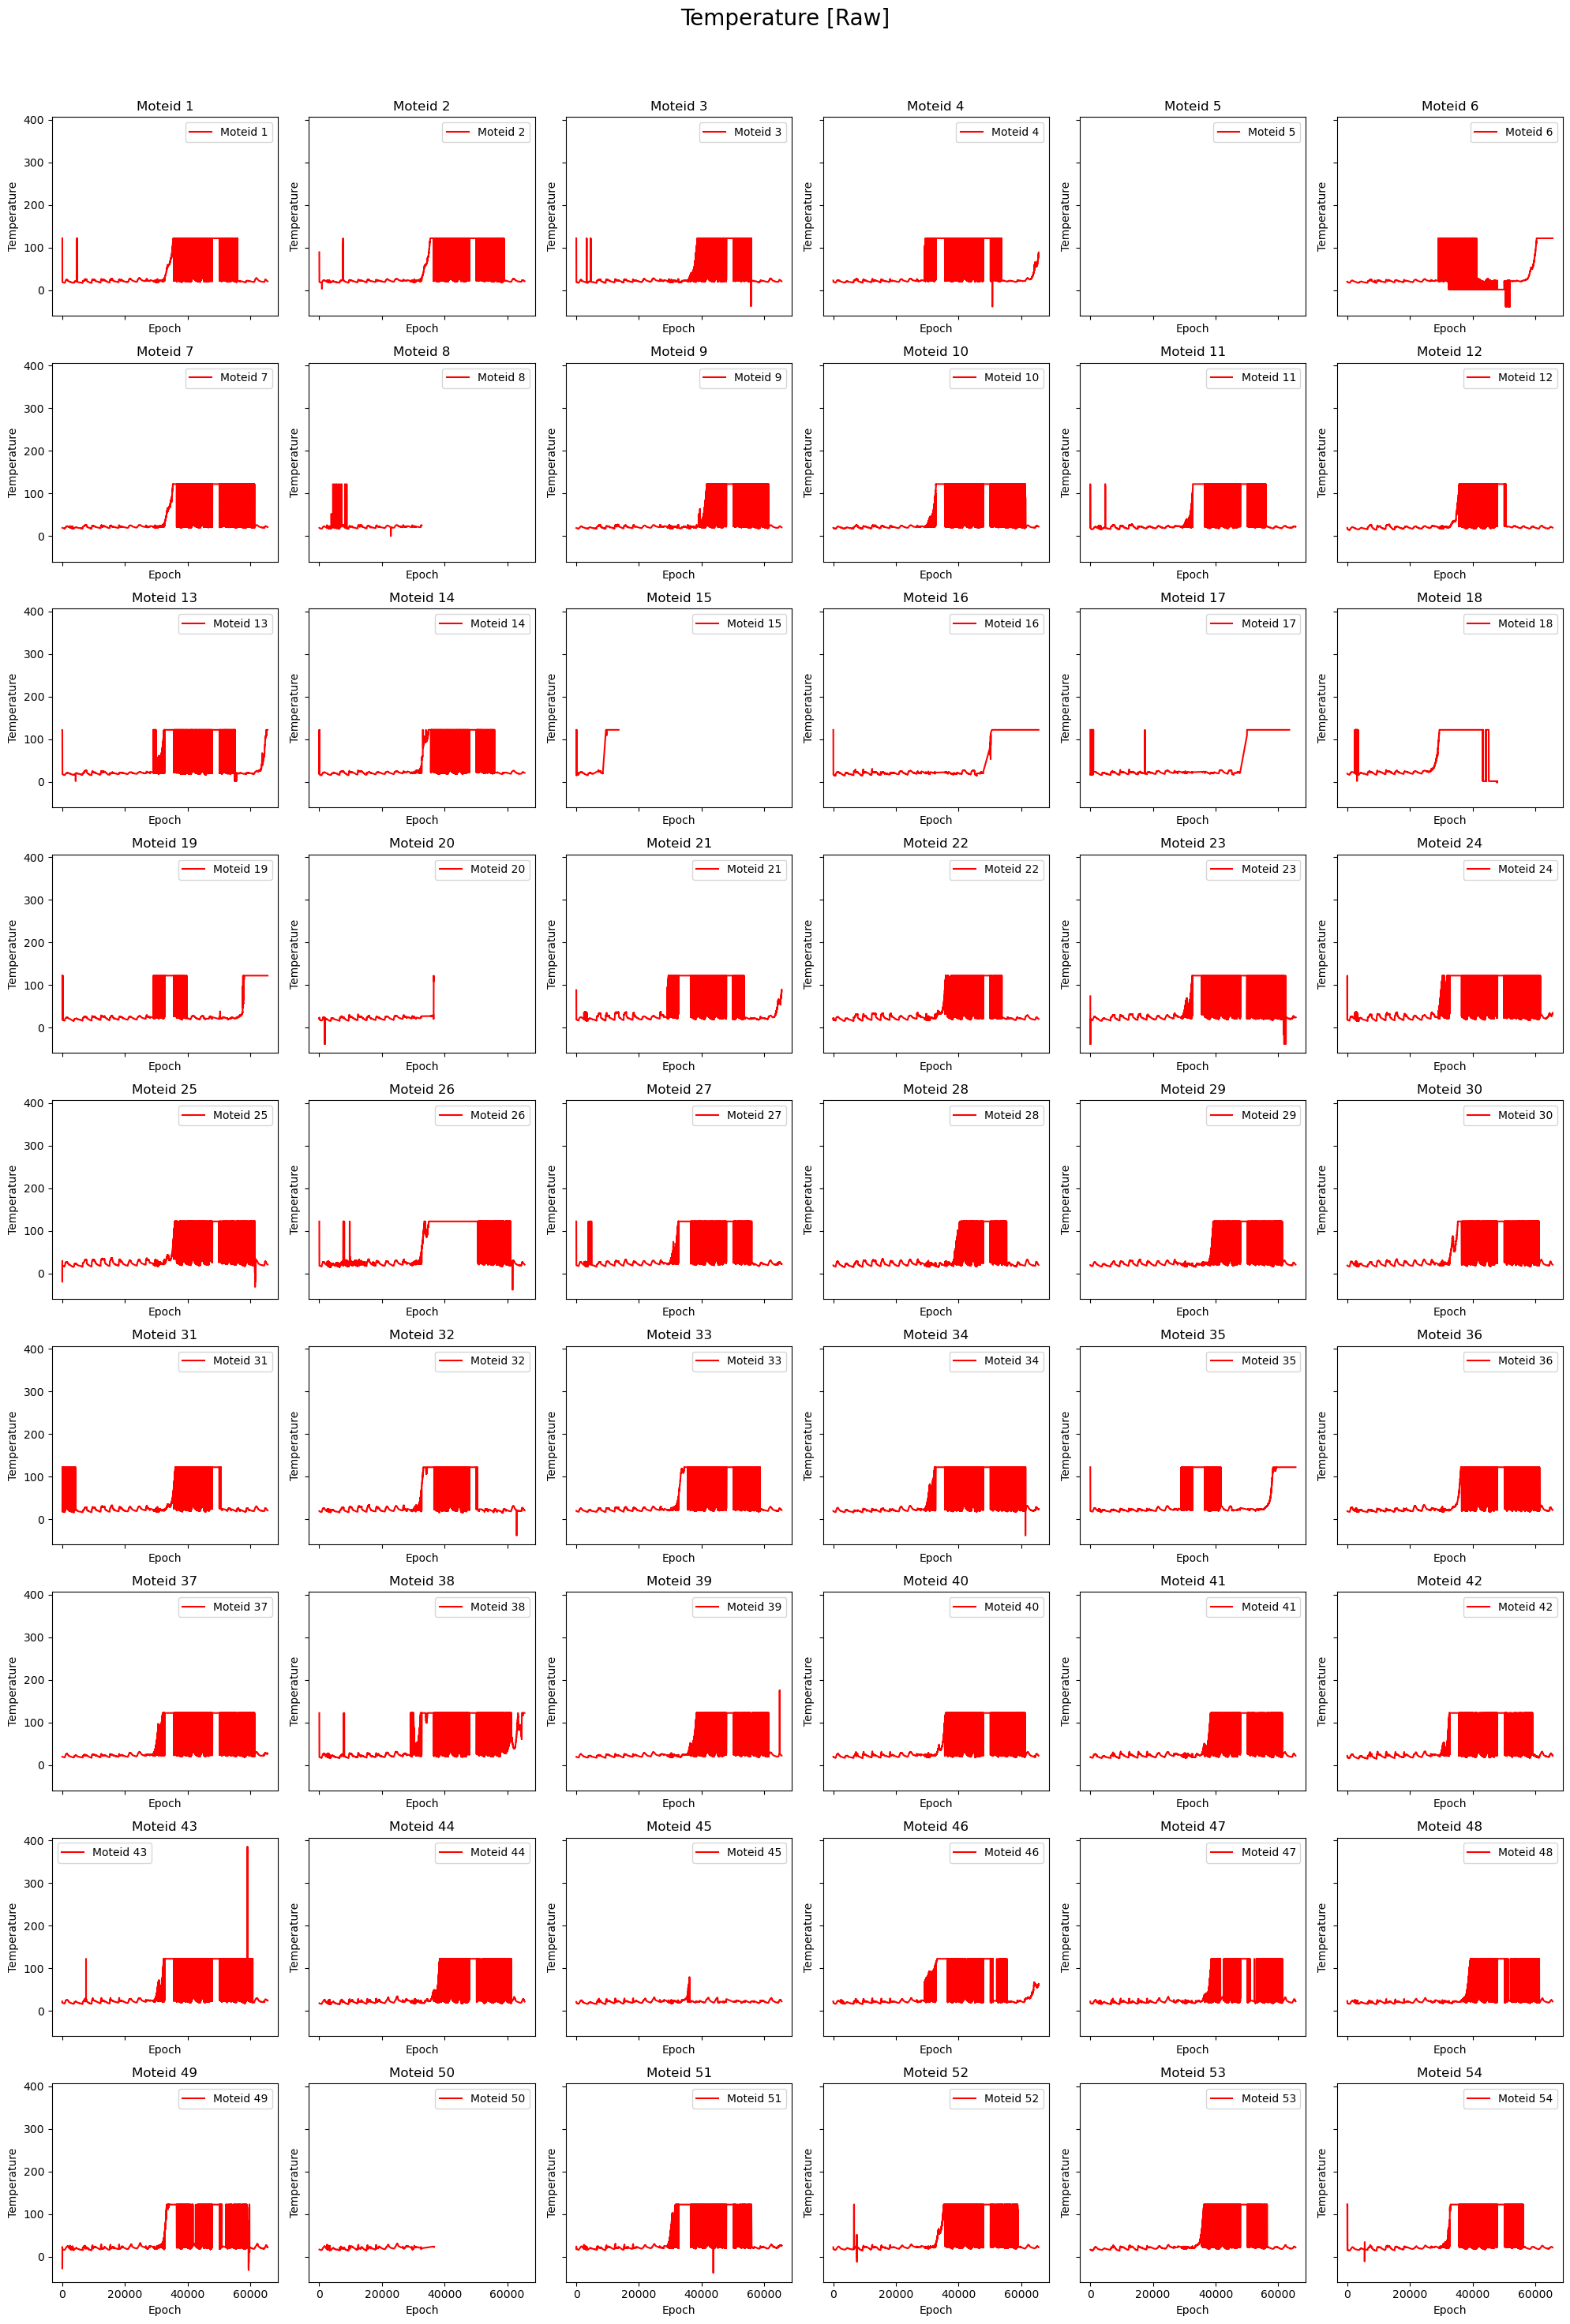

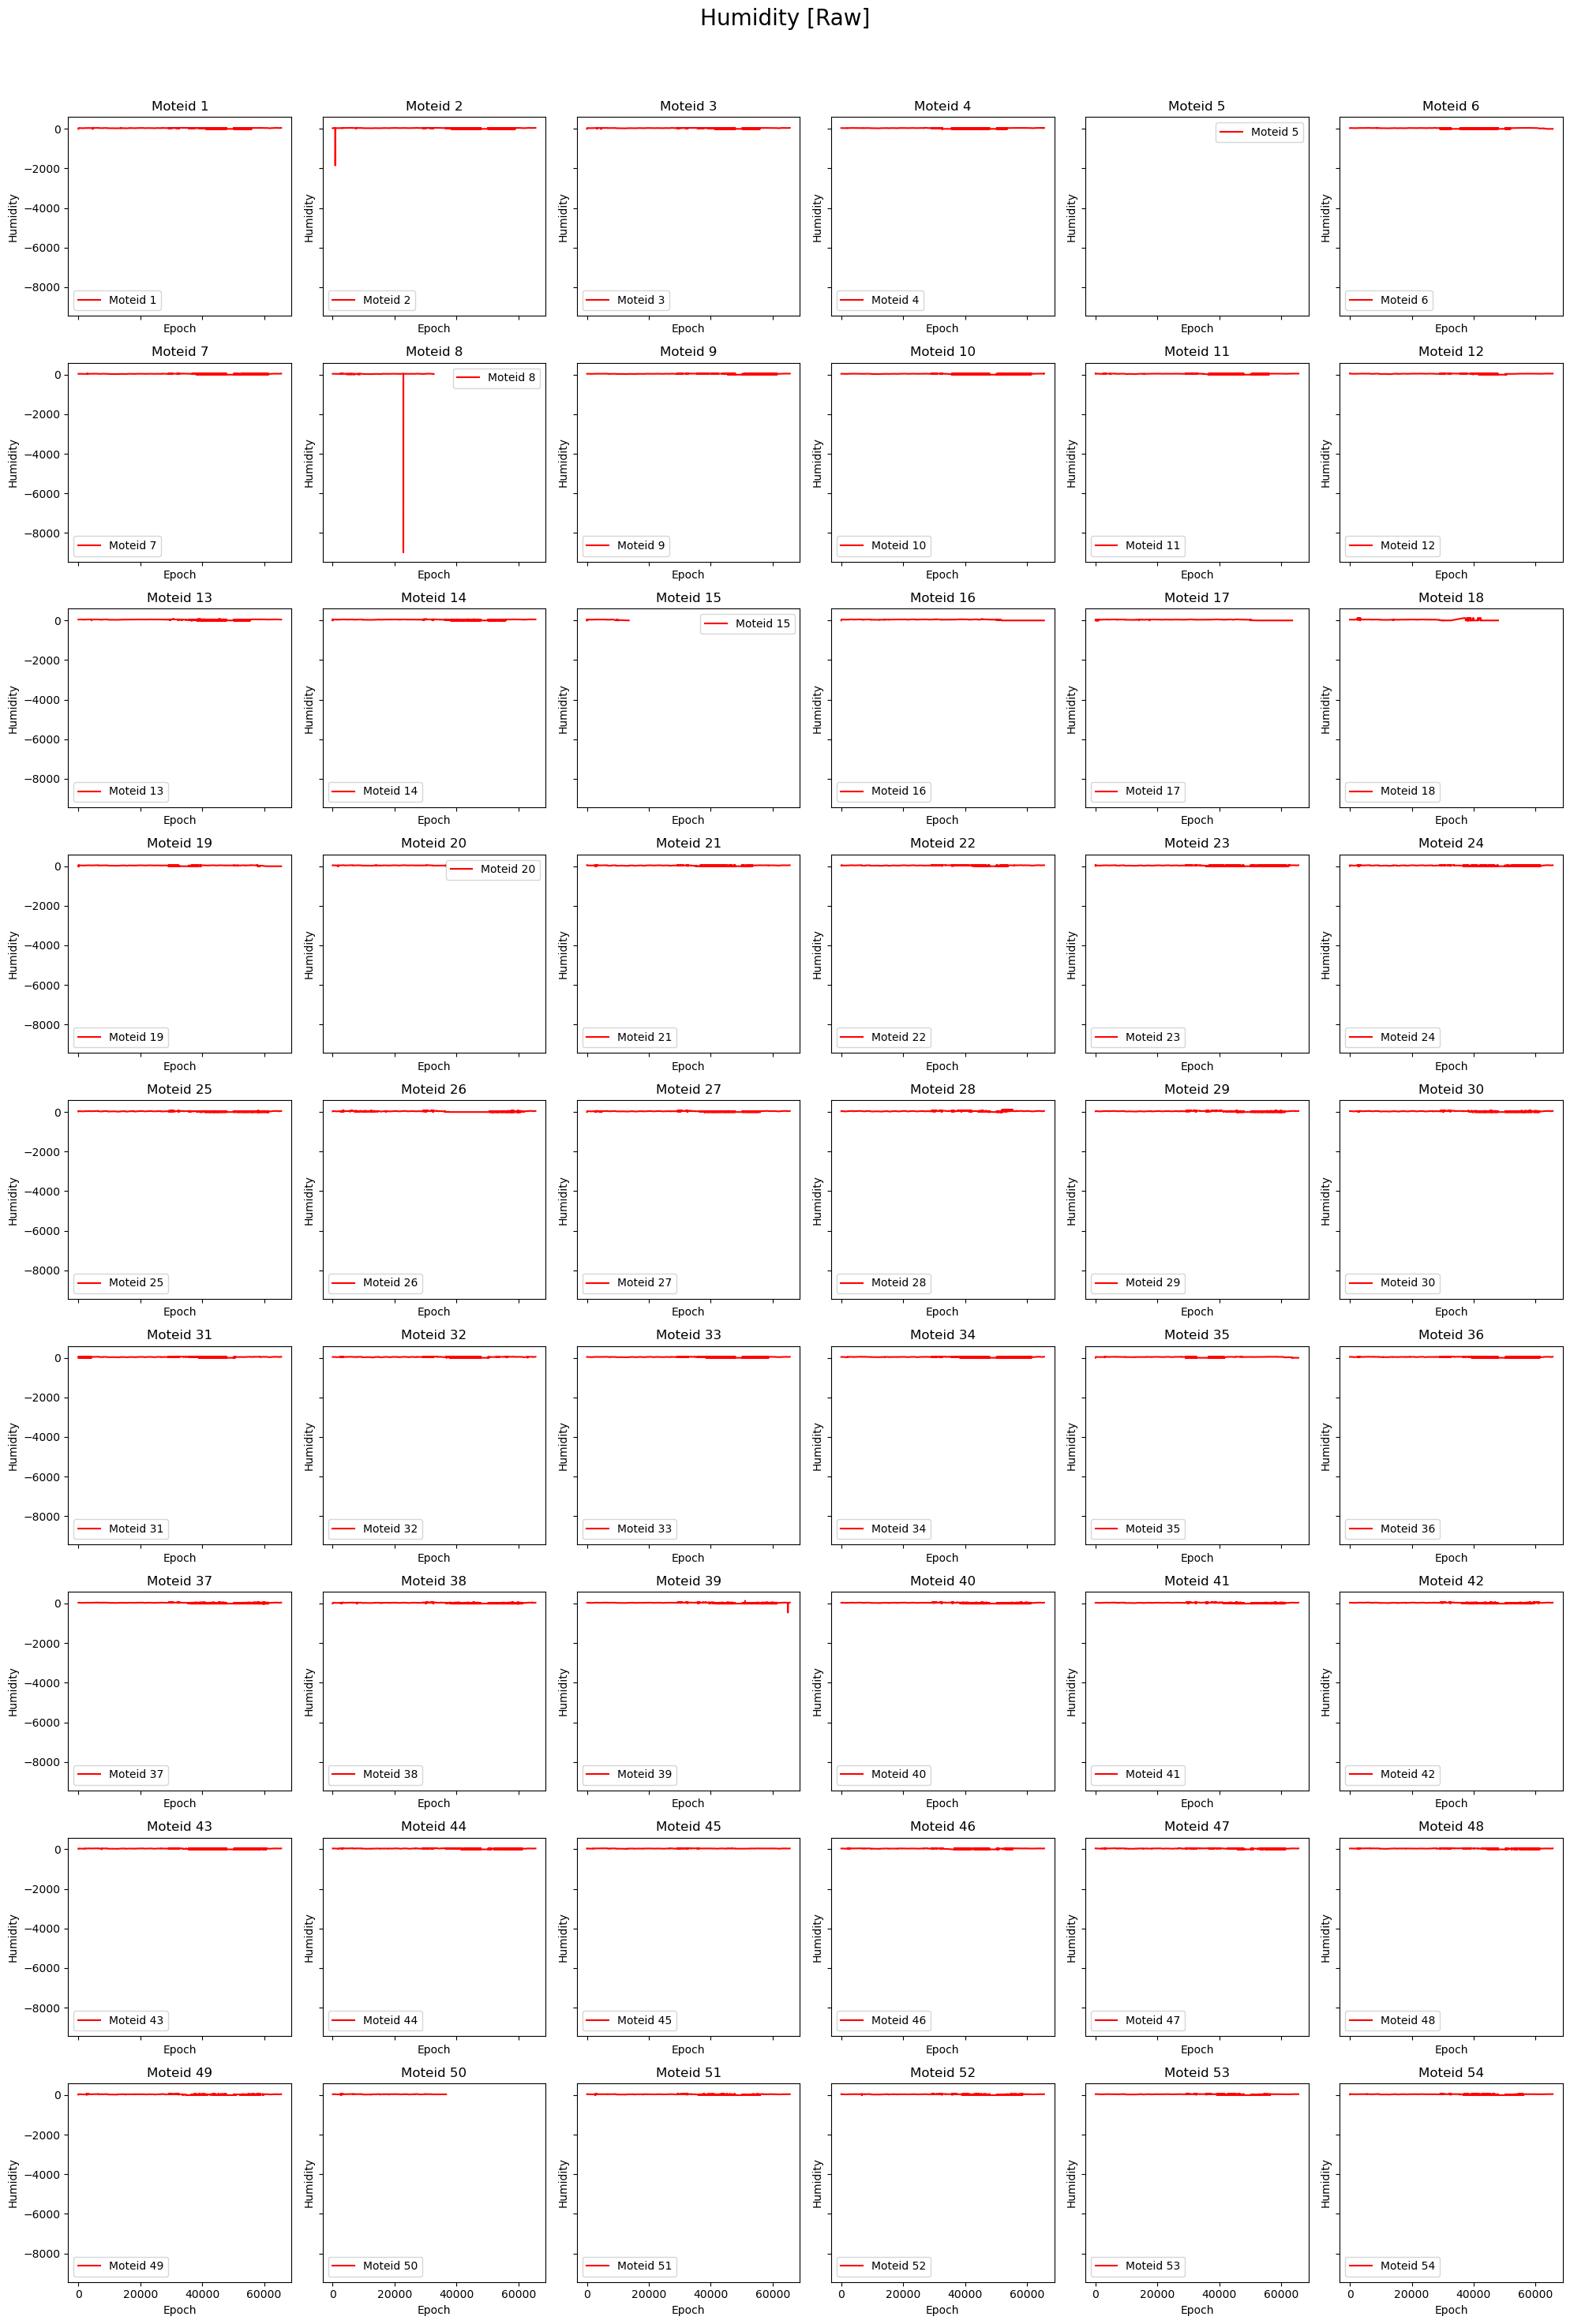

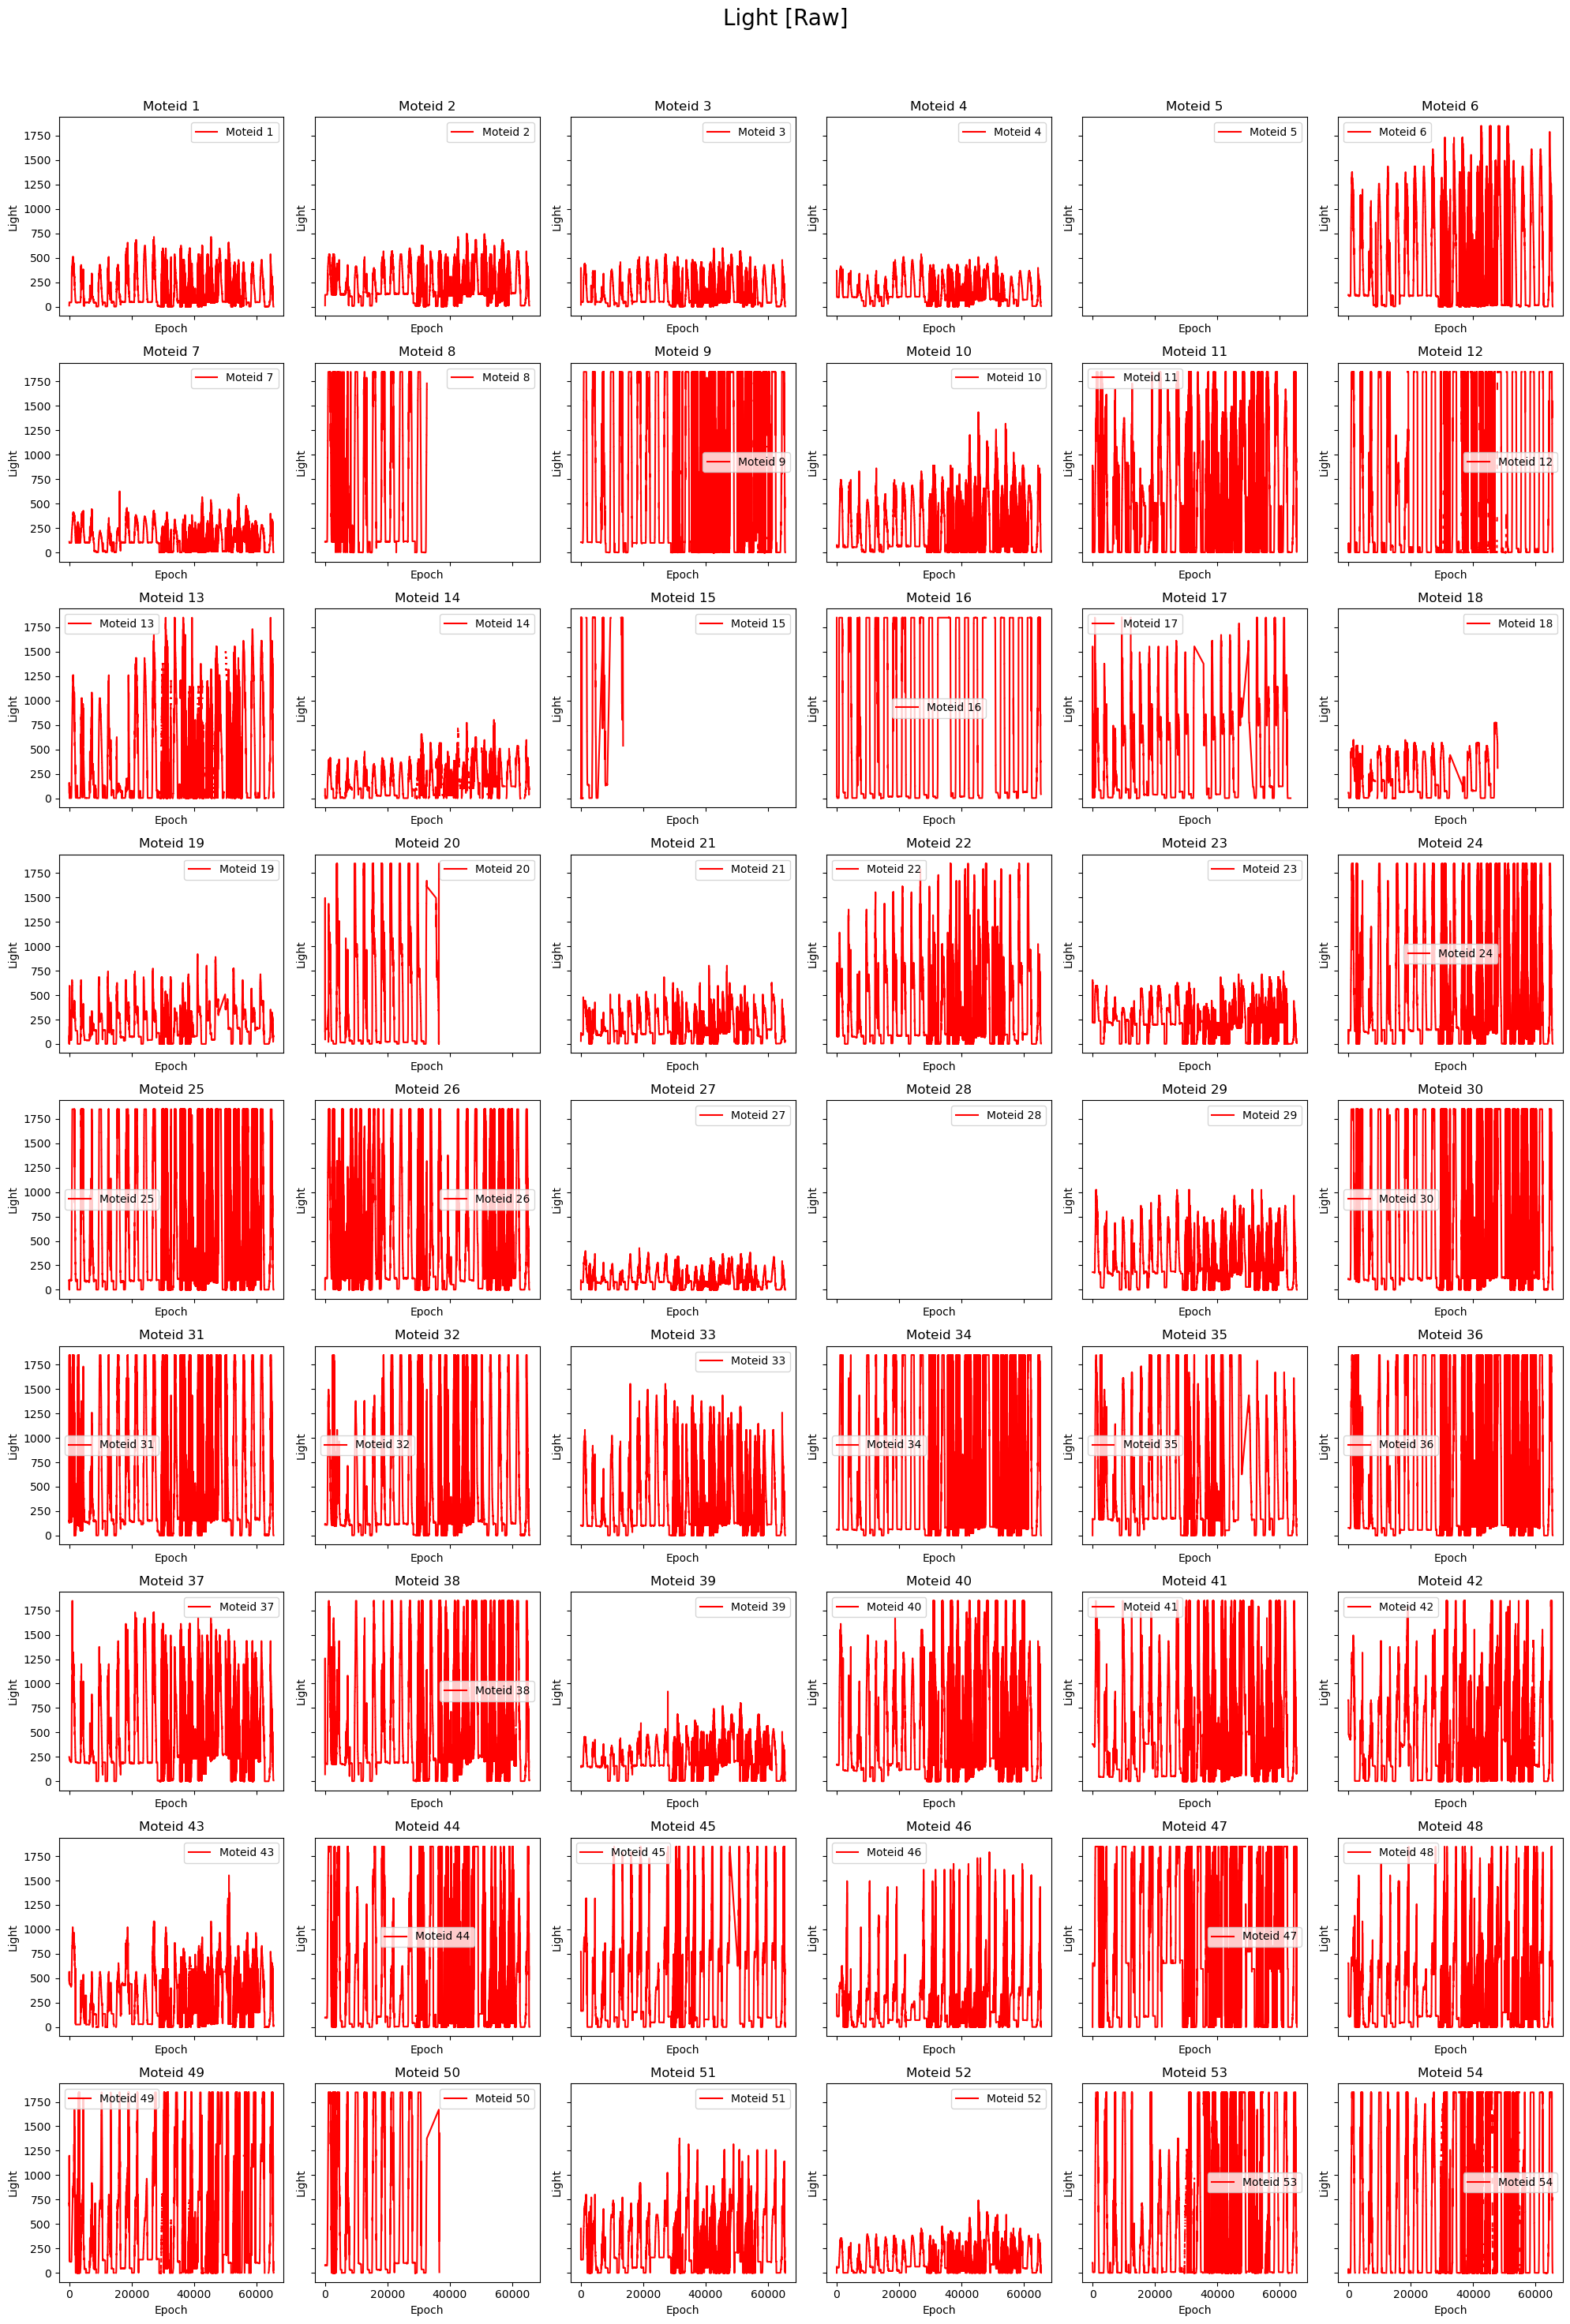

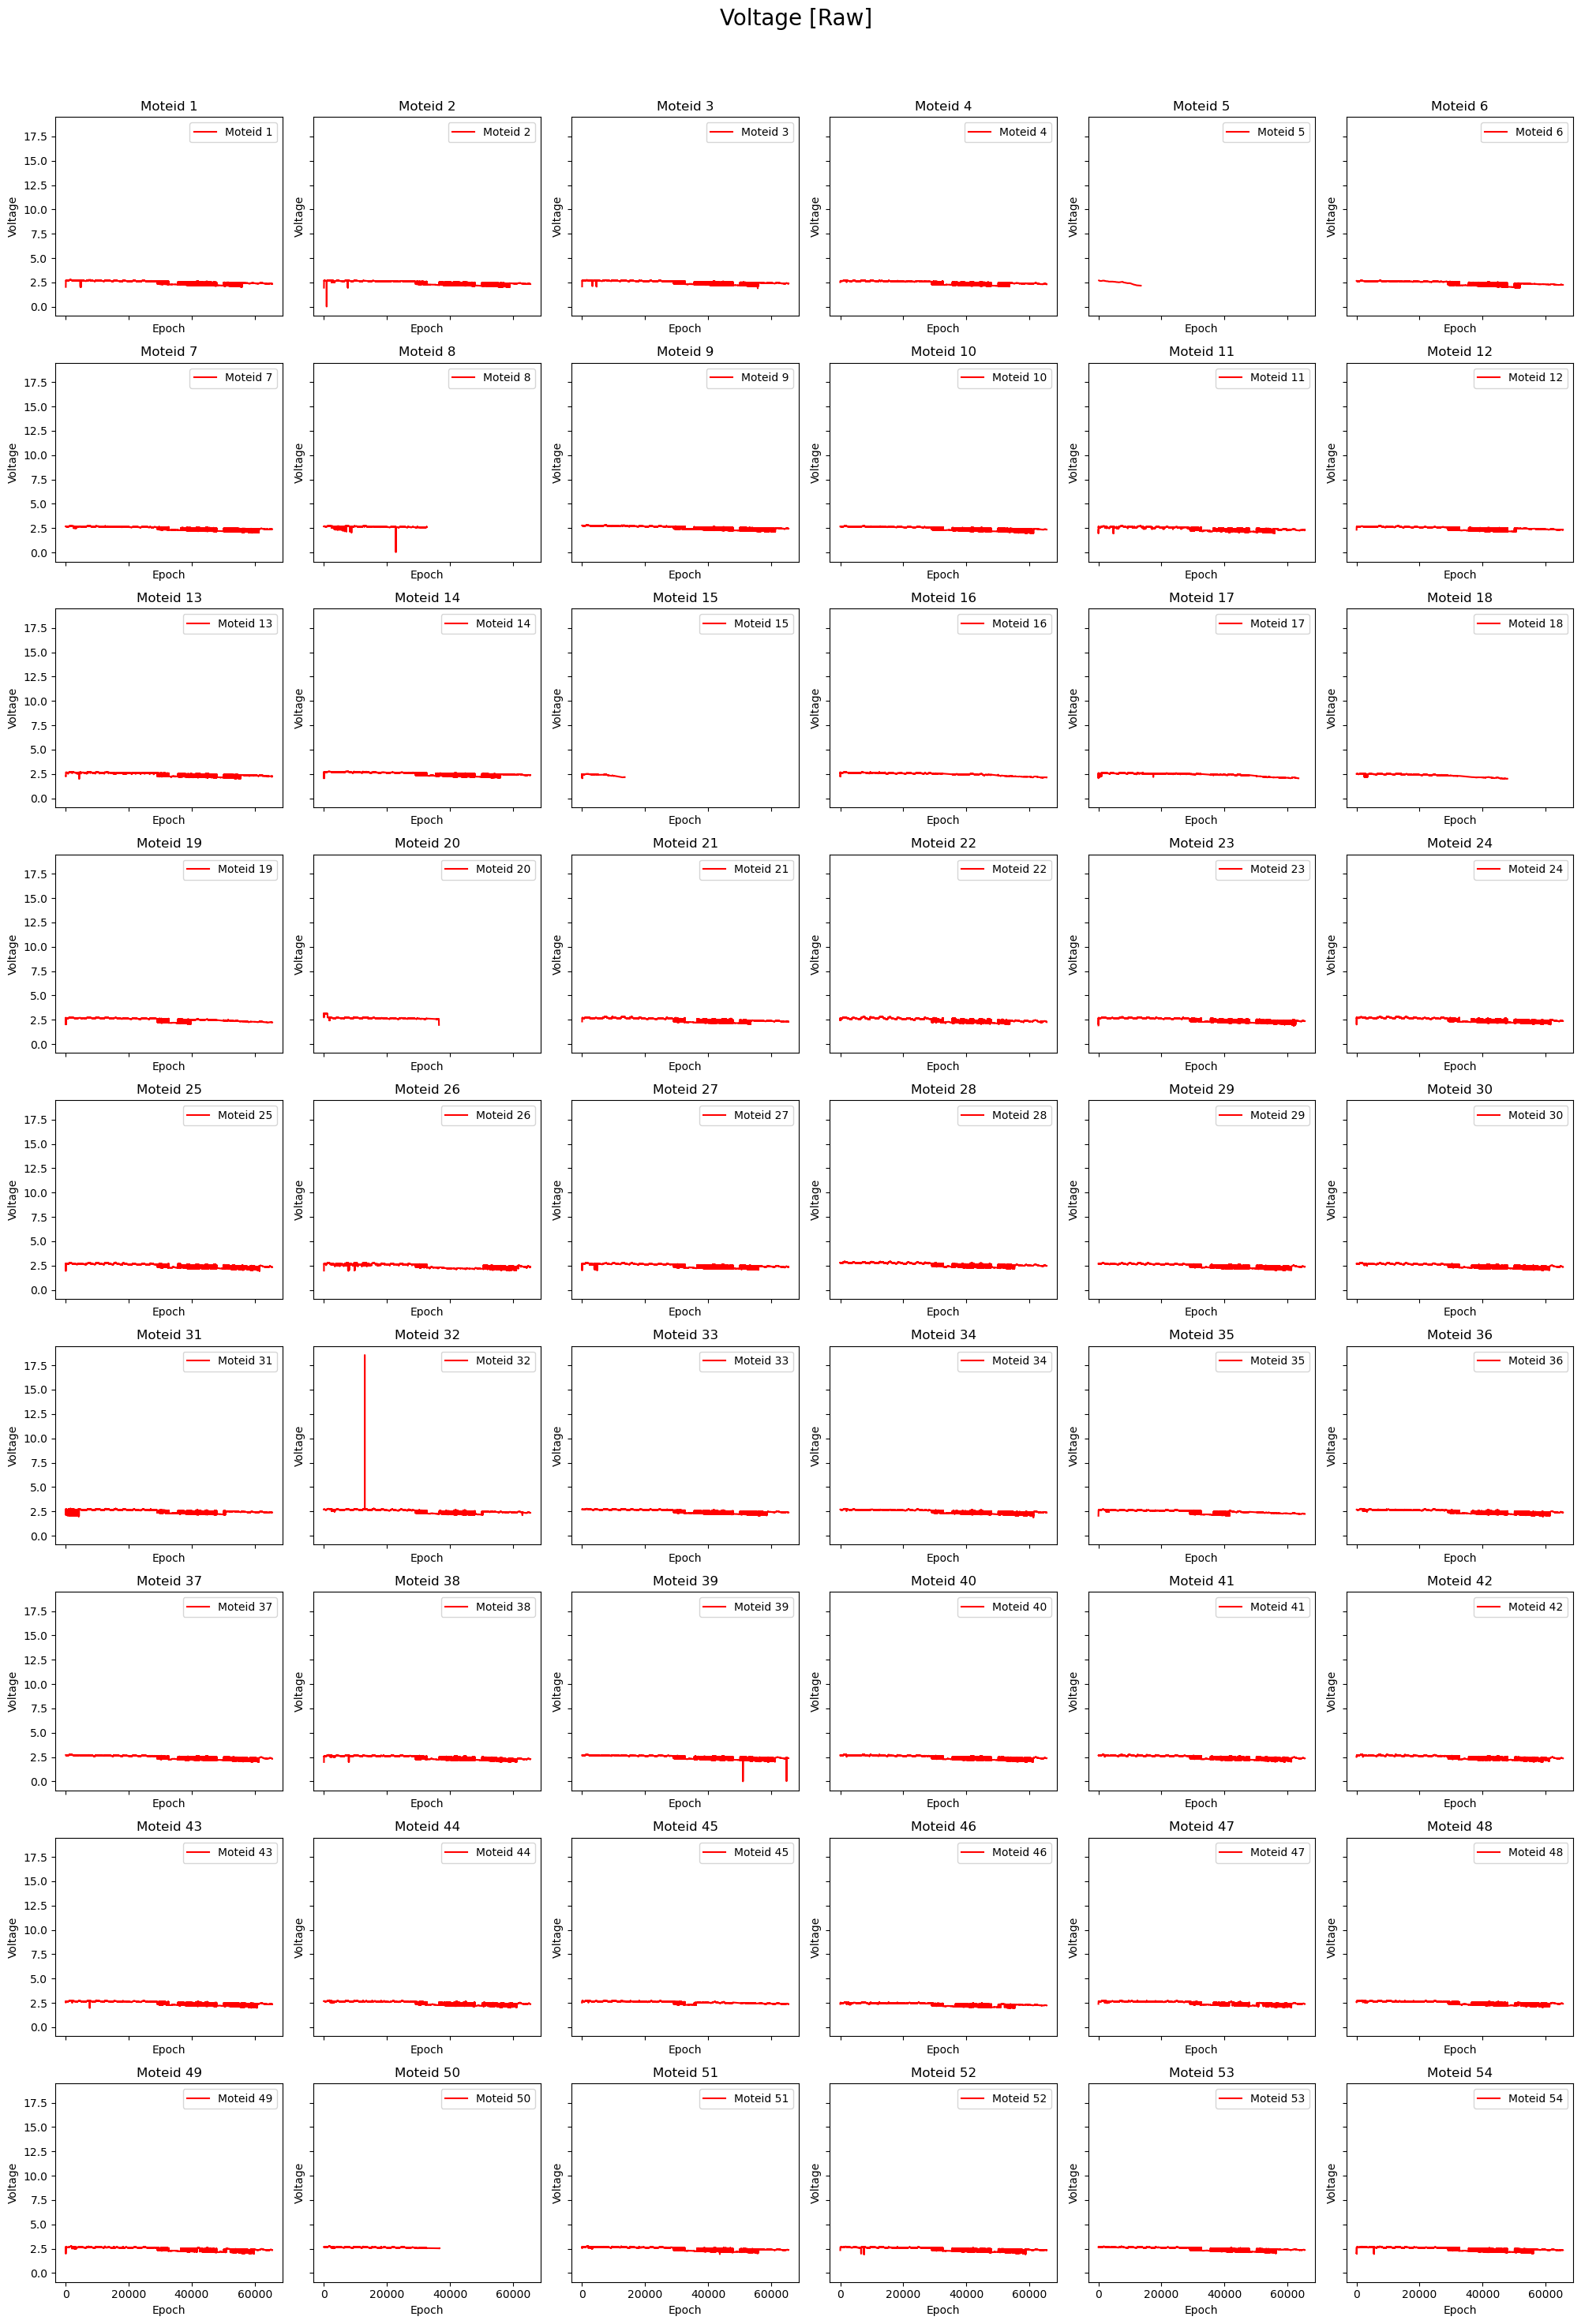

In [3]:
variables = ["temperature", "humidity", "light", "voltage"]

# Plot the temperature data for moteid 1 and epoch between 30000 and 40000
plt.figure(figsize=(20, 10))
plt.plot(data[(data["moteid"] == 1) & (data["epoch"] >= 0) & (data["epoch"] <= 1000000)]["epoch"],
         data[(data["moteid"] == 1) & (data["epoch"] >= 0) & (data["epoch"] <= 1000000)]["temperature"])
plt.title("Temperature data for moteid 1")
plt.xlabel("Epoch")
plt.ylabel("Temperature")
plt.show()


for variable in variables:
    fig, axes = plt.subplots(nrows=9, ncols=6, figsize=(20, 30), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for moteid in range(1, 55):
        moteid_data = data[data["moteid"] == moteid]
        ax = axes[moteid - 1]
        ax.plot(moteid_data["epoch"], moteid_data[variable], label=f"Moteid {moteid}", color='red')
        ax.set_title(f"Moteid {moteid}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(variable.capitalize())
        ax.legend()
    
    fig.suptitle(f"{variable.capitalize()} [Raw]", fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [4]:
# Replace out-of-range values with NaN for each column
for col, (low, high) in {
    "temperature": (-100, 100),
    "humidity": (0, 100),
    "light": (0, 2000),
    "voltage": (0, 10)
}.items():
    # Identify values outside the valid range and set them to NaN
    invalid = (data[col] < low) | (data[col] > high)
    data[col][invalid] = np.nan
    
# # Preview the loaded data
# print("Sample data:")
# print(data[:10])  # First 10 rows

# # Print the shape of the data
# print(f"Data shape: {data.shape}")

# Check for NaNs in each column
for col in ["temperature", "humidity", "light", "voltage"]:
    nan_count = np.isnan(data[col]).sum()  # Check for NaNs
    print(f"Number of NaNs in column '{col}': {nan_count}")

Number of NaNs in column 'temperature': 383813
Number of NaNs in column 'humidity': 299455
Number of NaNs in column 'light': 93205
Number of NaNs in column 'voltage': 1


In [5]:
for col in ["temperature", "humidity", "light", "voltage"]:

    ### Calculate the mean of the column, ignoring NaN ###
    # col_mean = np.nanmean(data[col])
    # data[col] = np.nan_to_num(data[col], nan=col_mean)


    ### Apply interpolation to each column ###
    # Identify indices of valid and missing values
    nans = np.isnan(data[col])
    not_nans = ~nans

    # Interpolate values
    interpolated = np.interp(
        x=np.flatnonzero(nans),        # Indices of NaNs
        xp=np.flatnonzero(not_nans),  # Indices of valid values
        fp=data[col][not_nans]           # Valid values
    )

    # Replace NaNs with interpolated values
    data[col][nans] = interpolated


# Verify the replacement
for col in ["temperature", "humidity", "light", "voltage"]:
    print(f"Number of NaNs in column '{col}' after interpolation: {np.isnan(data[col]).sum()}")


Number of NaNs in column 'temperature' after interpolation: 0
Number of NaNs in column 'humidity' after interpolation: 0
Number of NaNs in column 'light' after interpolation: 0
Number of NaNs in column 'voltage' after interpolation: 0


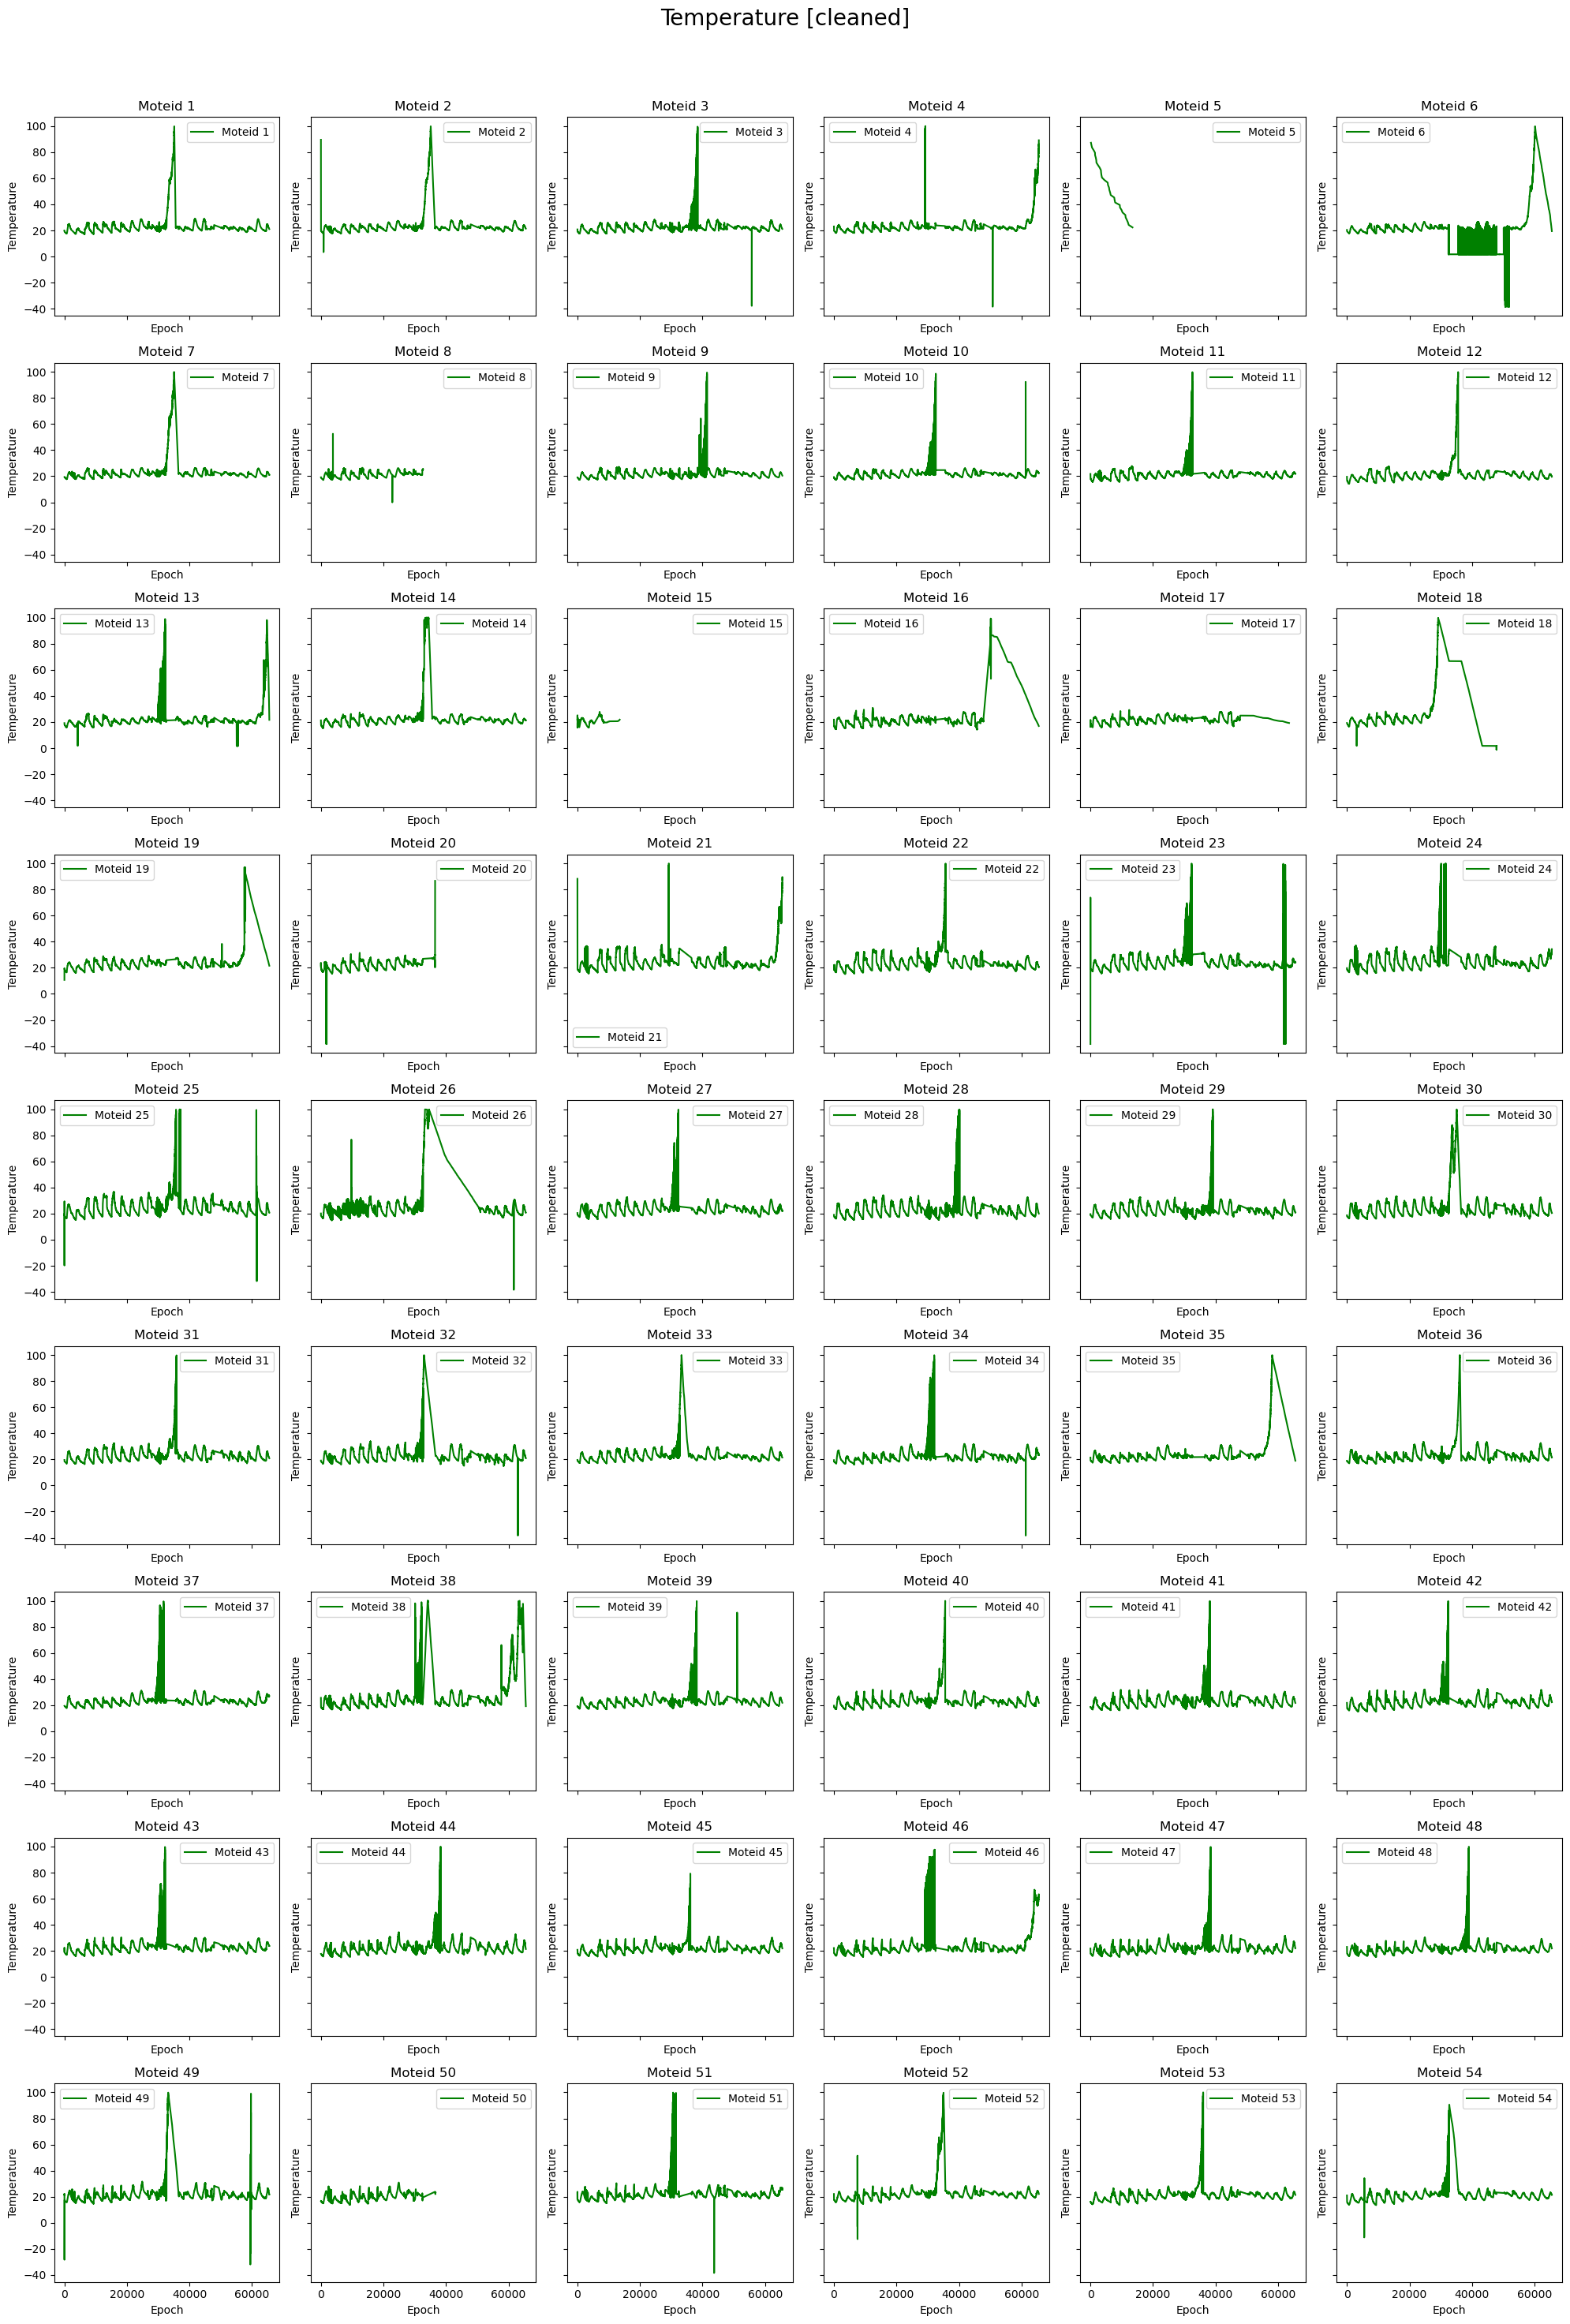

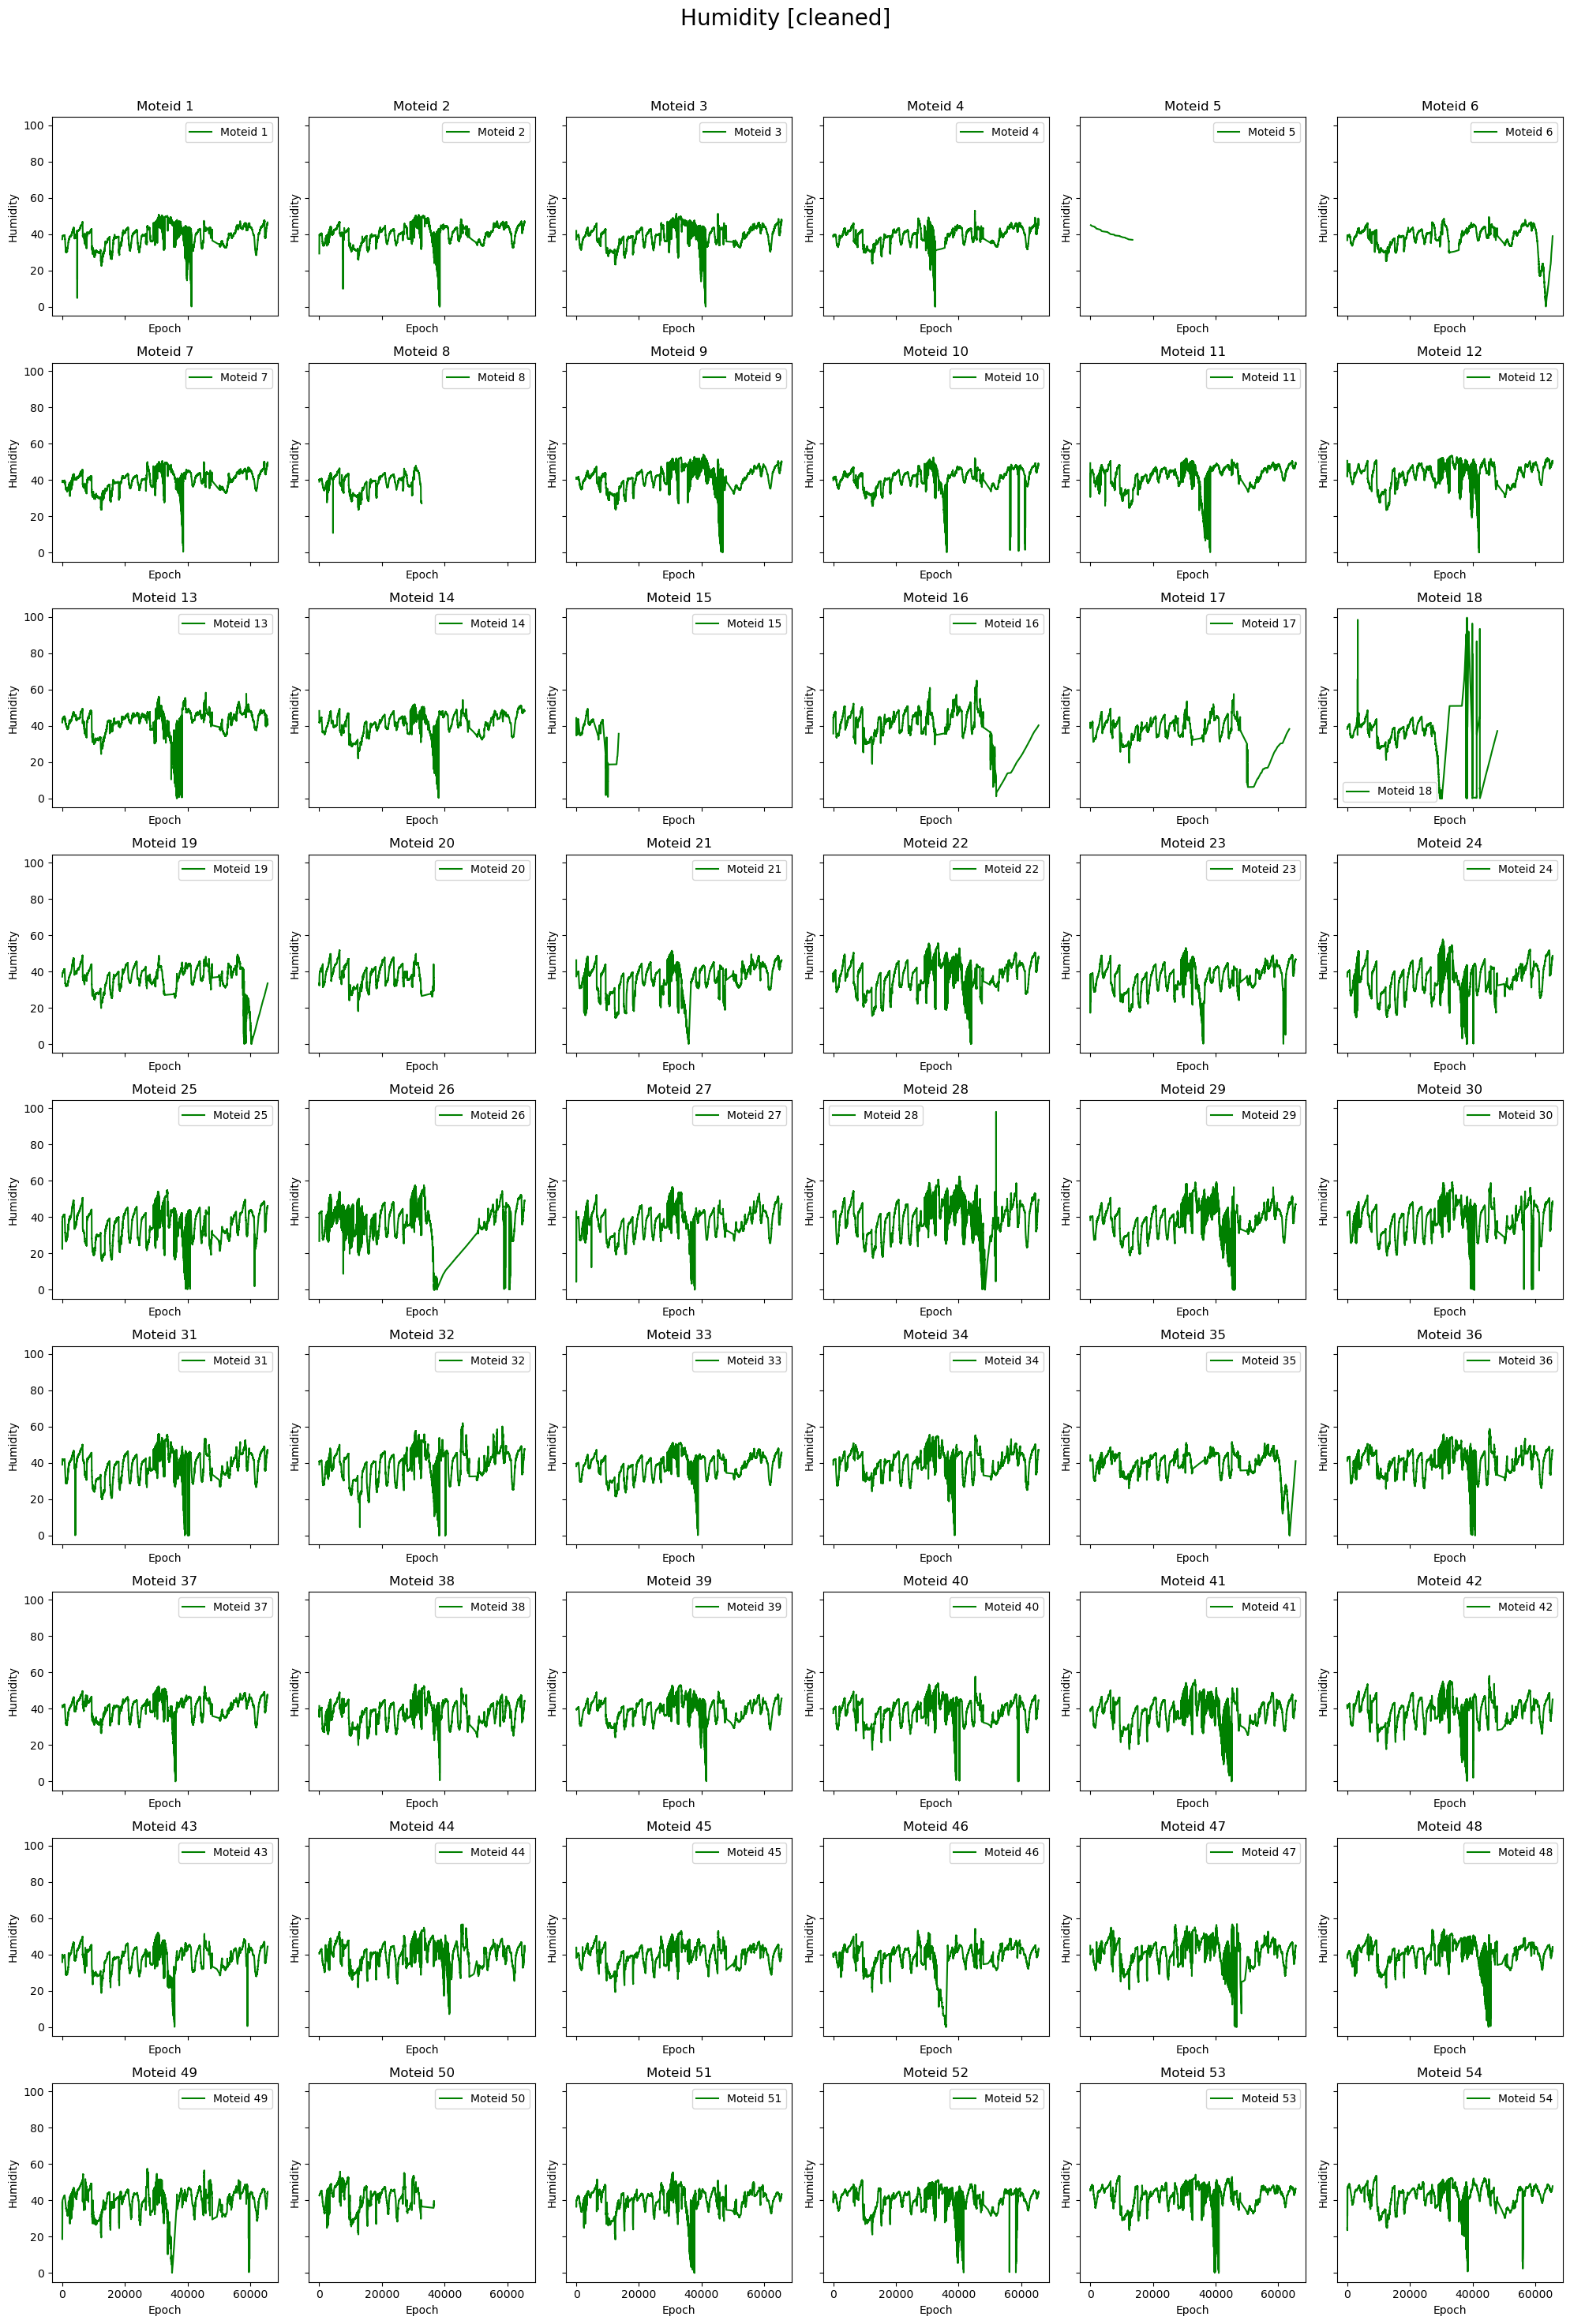

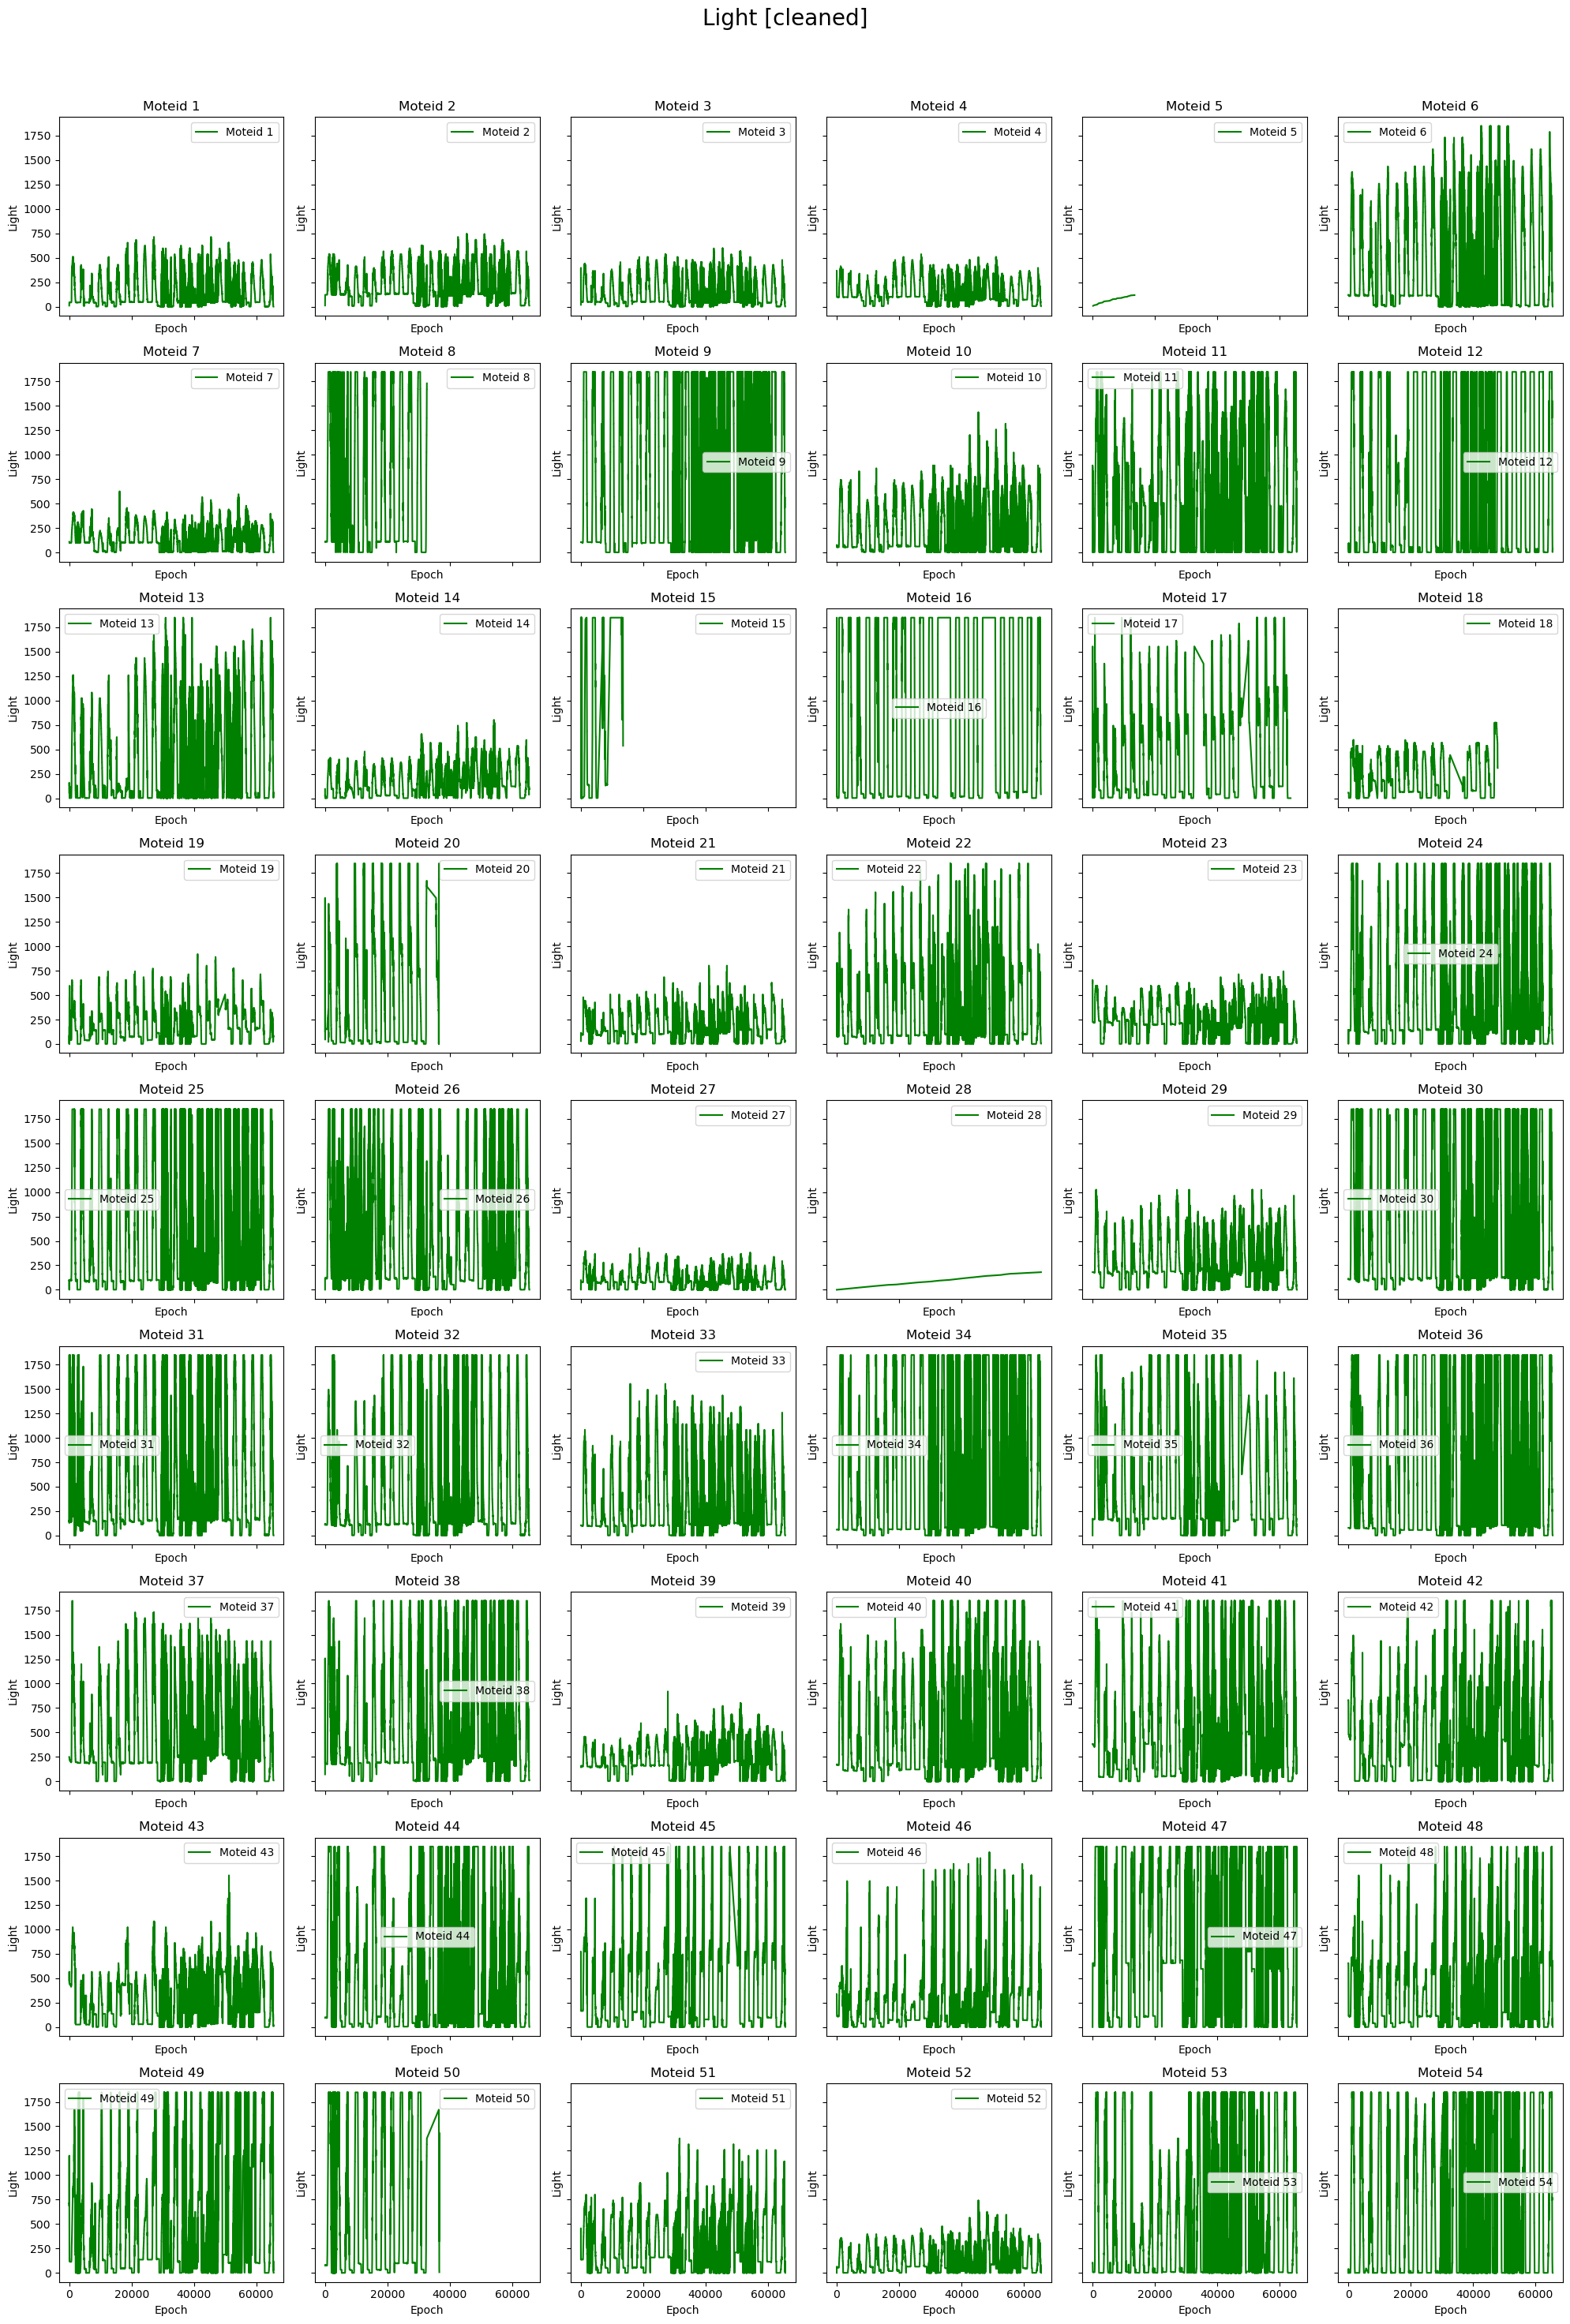

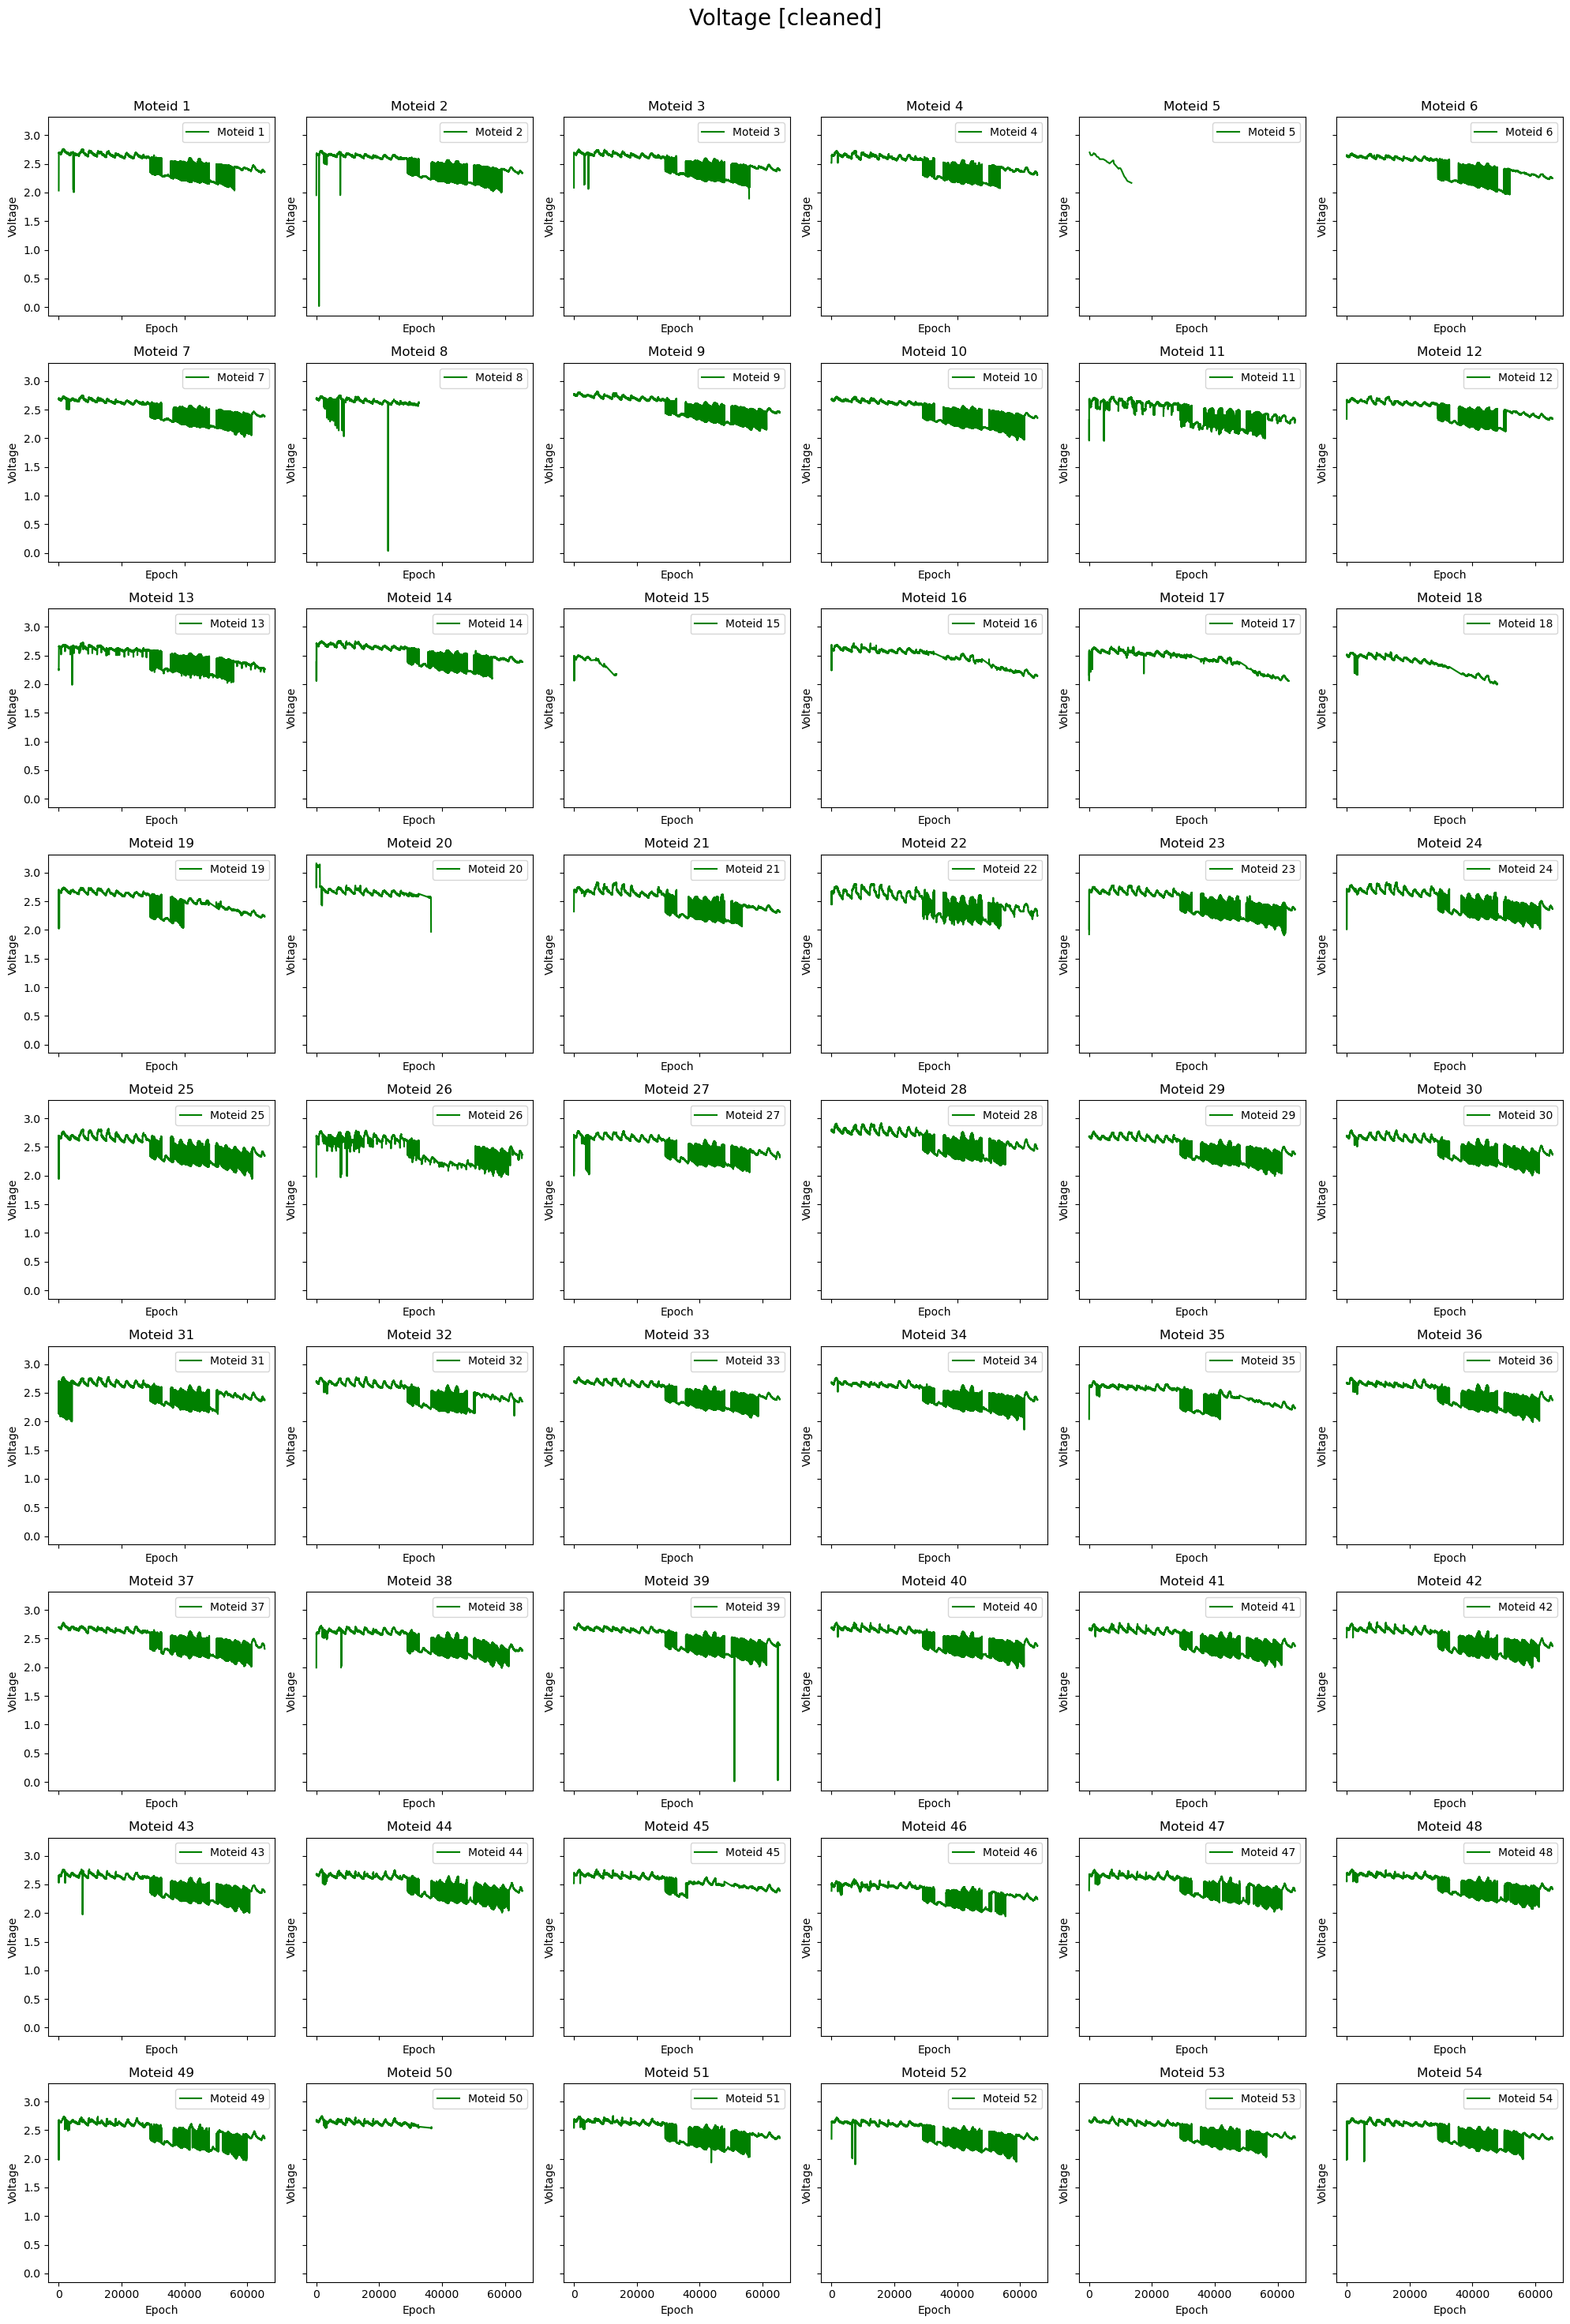

In [6]:
variables = ["temperature", "humidity", "light", "voltage"]

for variable in variables:
    fig, axes = plt.subplots(nrows=9, ncols=6, figsize=(20, 30), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for moteid in range(1, 55):
        moteid_data = data[data["moteid"] == moteid]
        ax = axes[moteid - 1]
        ax.plot(moteid_data["epoch"], moteid_data[variable], label=f"Moteid {moteid}", color='green')
        ax.set_title(f"Moteid {moteid}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(variable.capitalize())
        ax.legend()
    
    fig.suptitle(f"{variable.capitalize()} [cleaned]", fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [7]:
# make array (unstructured)
arr_data = np.column_stack([
    data["epoch"],
    data["moteid"],
    data["temperature"],
    data["humidity"],
    data["light"],
    data["voltage"]
])

# Cast array to float32
arr_data = arr_data.astype(np.float32)

# unique epochs
unique_epochs = np.unique(arr_data[:, 0]) 

# For each epoch, select the rows belonging to that epoch
submatrices = []
for ep in unique_epochs:
    mask = (arr_data[:, 0] == ep)
    sub_matrix = arr_data[mask]  # shape (rows_for_this_epoch, 6)
    submatrices.append(sub_matrix)


# Concatenate the submatrices
concat_data = np.vstack(submatrices)

# Sort the concatenated matrix by epoch
sorted_matrix = concat_data[ concat_data[:, 0].argsort() ]

print("Final matrix shape:", sorted_matrix.shape)

Final matrix shape: (2303290, 6)
